In [12]:
import pathlib
import re
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers as L                   
from keras.applications import MobileNetV2      
from keras.applications.mobilenet_v2 import preprocess_input

In [13]:
import os
import gc

tf.keras.backend.clear_session()   # drop everything from the prior model
gc.collect()                       # free Python-side objects as well

# optional but recommended if you allocated a lot previously
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [14]:
# Configuration Constants
DATA_ROOT   = pathlib.Path("../Datasets")          # <- adjust if needed
IMG_SIZE    = (224, 224)                        # images are 224×224×3
BATCH_SIZE  = 32
EPOCHS      = 30
SEED        = 42

# --- 1. Collect file paths ----------------------------------------------------
train_files, train_labels = [], []
test_files , test_labels  = [], []

class_names = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
class_to_idx = {c: i for i, c in enumerate(class_names)}

pattern = re.compile(r"(\d+)\.(jpg|jpeg|png)$", re.IGNORECASE)

for cls in class_names:
    for fp in (DATA_ROOT / cls).iterdir():
        m = pattern.search(fp.name)
        if not m:                    # skip non-image files
            continue
        idx = int(m.group(1))
        target = test_files if idx % 5 == 0 else train_files
        labels = test_labels if idx % 5 == 0 else train_labels
        target.append(str(fp))
        labels.append(class_to_idx[cls])

print(f"Train images: {len(train_files)}, Test images: {len(test_files)}")

Train images: 692, Test images: 170


In [15]:
# --- 2. Build tf.data datasets ------------------------------------------------
def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load(f, y):
        img = tf.io.read_file(f)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = preprocess_input(img)            # MobileNetV2 preprocessing
        return img, tf.one_hot(y, len(class_names))

    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        aug = tf.keras.Sequential([
            L.RandomFlip("horizontal"),
            L.RandomRotation(0.05),
            L.RandomZoom(0.1)
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1024, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_files, train_labels, training=True)
test_ds  = make_ds(test_files , test_labels , training=False)

In [16]:
# --- 3. Build & compile the model --------------------------------------------
base = MobileNetV2(input_shape=IMG_SIZE + (3,), weights="imagenet",
                   include_top=False)
base.trainable = False                       # first train only the head

model = tf.keras.Sequential([
    base,
    L.GlobalAveragePooling2D(),
    L.Dropout(0.25),
    L.Dense(len(class_names), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [17]:
# --- 4. Train (head only) -----------------------------------------------------
hist_head = model.fit(train_ds,
                 epochs=EPOCHS,
                 validation_data=test_ds,
                 callbacks=[
                     tf.keras.callbacks.EarlyStopping(patience=6,
                                                     restore_best_weights=True)
                 ])

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.3390 - loss: 1.6790 - val_accuracy: 0.6706 - val_loss: 0.8948
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6895 - loss: 0.8717 - val_accuracy: 0.7882 - val_loss: 0.6439
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8161 - loss: 0.5825 - val_accuracy: 0.8294 - val_loss: 0.5233
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7976 - loss: 0.5433 - val_accuracy: 0.8529 - val_loss: 0.4621
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8419 - loss: 0.4741 - val_accuracy: 0.8412 - val_loss: 0.4146
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9060 - loss: 0.3549 - val_accuracy: 0.8882 - val_loss: 0.3693
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8748 - loss: 0.3623 - val_accuracy: 0.8941 - val_loss: 0.3393
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9283 - loss: 0.2823 - val_accuracy: 0.9000 - 

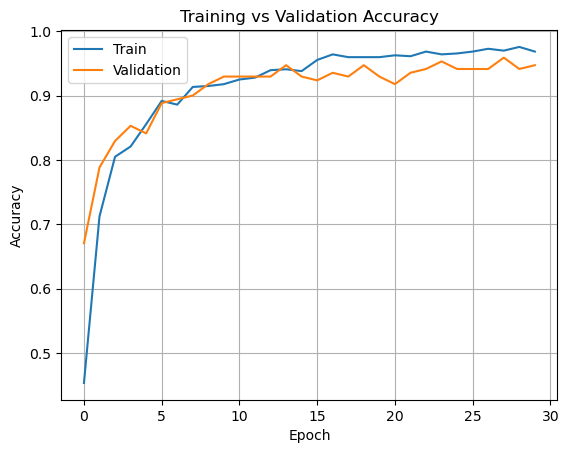

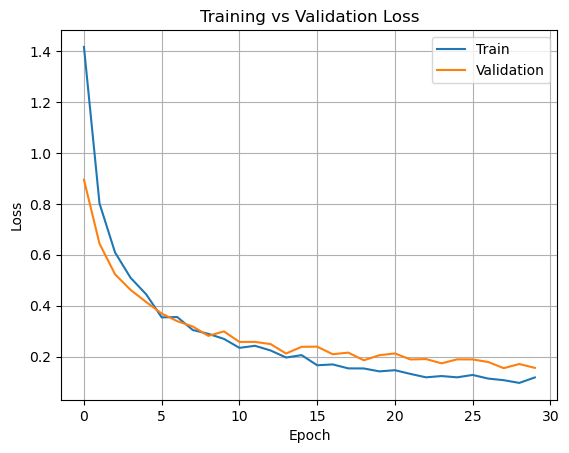

In [18]:
# 1) Accuracy history ----------------------------------------------------------
acc      = hist_head.history["accuracy"]
val_acc  = hist_head.history["val_accuracy"]

plt.figure()                    # one distinct plot
plt.plot(acc,     label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 2) Loss history --------------------------------------------------------------
loss     = hist_head.history["loss"]
val_loss = hist_head.history["val_loss"]

plt.figure()                    # second distinct plot
plt.plot(loss,     label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [19]:
# --- 5. Optional fine-tuning ---------------------------------------------------
base.trainable = True
for layer in base.layers[:-20]:              # unfreeze last ~20 layers only
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
hist_ft = model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=test_ds,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=6,
                                               restore_best_weights=True)
          ])

Epoch 1/30


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.8552 - loss: 0.3709 - val_accuracy: 0.8765 - val_loss: 0.3811
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9567 - loss: 0.1223 - val_accuracy: 0.8765 - val_loss: 0.3714
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9817 - loss: 0.0831 - val_accuracy: 0.8647 - val_loss: 0.4277
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9844 - loss: 0.0542 - val_accuracy: 0.8706 - val_loss: 0.4458
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9920 - loss: 0.0419 - val_accuracy: 0.8882 - val_loss: 0.3816
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9937 - loss: 0.0422 - val_accuracy: 0.8941 - val_loss: 0.3946
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9889 - loss: 0.0436 - val_accuracy: 0.9118 - val_loss: 0.3164
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.9176 - val_loss: 

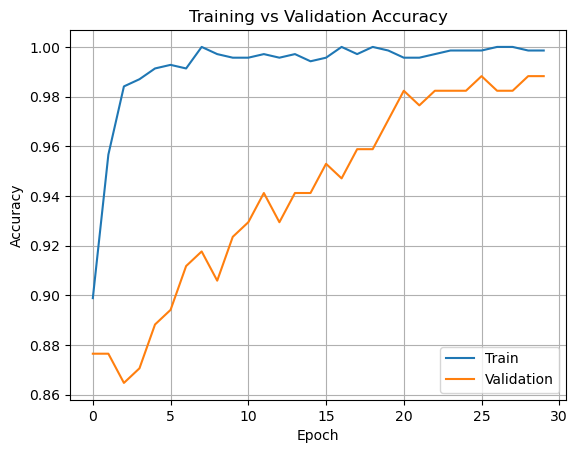

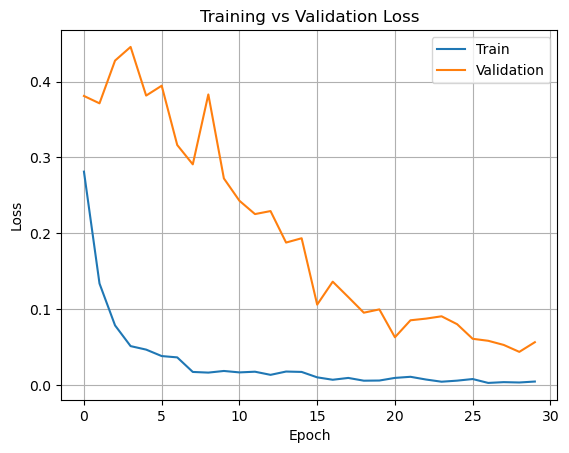

In [20]:
# 1) Accuracy history ----------------------------------------------------------
acc      = hist_ft.history["accuracy"]
val_acc  = hist_ft.history["val_accuracy"]

plt.figure()                    # one distinct plot
plt.plot(acc,     label="Train")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 2) Loss history --------------------------------------------------------------
loss     = hist_ft.history["loss"]
val_loss = hist_ft.history["val_loss"]

plt.figure()                    # second distinct plot
plt.plot(loss,     label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [21]:
# --- 6. Inspect mis-classifications ------------------------------------------
y_true, y_pred, file_paths = [], [], []

for (x, y), paths in zip(test_ds.unbatch(), np.array(test_files)):
    logits = model(tf.expand_dims(x, 0), training=False)
    y_true.append(tf.argmax(y).numpy())
    y_pred.append(tf.argmax(logits, axis=1).numpy()[0])
    file_paths.append(paths)

mis_idx = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
print("\nMis-classified samples (truth -> pred):")
for i in mis_idx:
    print(f"{file_paths[i]} : {class_names[y_true[i]]} → {class_names[y_pred[i]]}")



Mis-classified samples (truth -> pred):
../Datasets/False_Smut/80.jpeg : False_Smut → Brown_Spot
../Datasets/Healthy/45.jpeg : Healthy → Brown_Spot


2025-06-22 09:07:04.129378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
def report_best_acc(head_hist, ft_hist=None, label="Model"):
    """
    head_hist : History object returned by the head-only fit
    ft_hist   : optional History from fine-tune fit  (None → single phase)
    label     : name to print in the header
    """
    # Concatenate lists
    train_acc = head_hist.history["accuracy"] + (ft_hist.history["accuracy"]        if ft_hist else [])
    val_acc   = head_hist.history["val_accuracy"] + (ft_hist.history["val_accuracy"] if ft_hist else [])

    best_train = max(train_acc)
    best_val   = max(val_acc)

    print(f"── {label} ─────────────────────────────────────────")
    print(f"   best TRAIN accuracy : {best_train:.4f}")
    print(f"   best TEST  accuracy : {best_val  :.4f}")
    print("")

# ▸ Example for EfficientNet or ResNet (two-phase)
report_best_acc(hist_head, hist_ft, label="MobileNetV2")

── MobileNetV2 ─────────────────────────────────────────
   best TRAIN accuracy : 1.0000
   best TEST  accuracy : 0.9882

